<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/rice_seed_shape_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# イネ種子形状解析

446粒分のイネ種子

## ライセンス
- 公式レポ由来Mask R-CNN関連前処理後処理コードは　（https://github.com/matterport/Mask_RCNN/tree/master）
    - MIT License
- イネ種子Instance Segmenatation用モデルファイル
    - Apache 2.0
- その他実行コード
    - Apache 2.0

## 解説

## 環境構築・データ準備

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [2]:
!pip install onnx onnxruntime-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.0 MB/s eta 0:00:00


## クラシカルな画像解析アプローチによる種子計測

最もシンプルなアプローチを試してましょう
1. グレースケール化
2. 閾値による背景分離
3. skimageのlabel, regionpropsによる領域計測

In [217]:
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage as ndi
from skimage.color import rgb2gray, label2rgb
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed

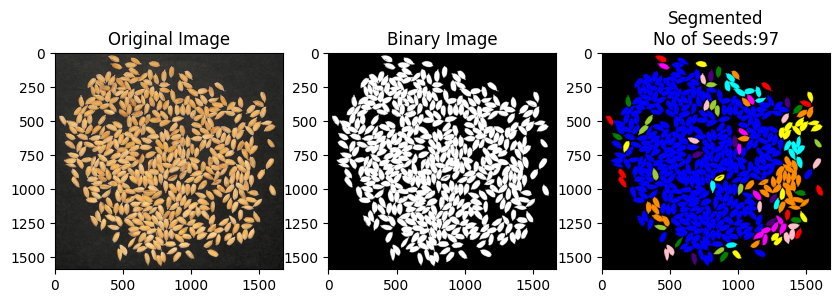

In [215]:
# 画像の読み込み
image = cv2.imread("/content/drive/MyDrive/phenotyping_temp_assets/rice.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 大津法による閾値の算出と背景分離
gray = rgb2gray(image)
threshold = threshold_otsu(gray)

# 閾値以上の明るさを物体、それ以外を背景としてbinary化
binary = gray > threshold

# 領域ラベル変換
lbl_image = label(binary)

# Count Seeds
# 種子の数は　ユニークなラベル数値から背景（値が0）を１つ分引いたものに相当
seed_no = len(np.unique(lbl_image)) - 1

# Convert label image to RGB image。可視化用
segmented = label2rgb(lbl_image)


# Visualize the segmented regions
plt.figure(figsize=(10, 6))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(132)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')

plt.subplot(133)
plt.imshow(segmented, cmap='nipy_spectral')
plt.title("Segmented\nNo of Seeds:"+str(seed_no))
plt.show()

上記の右側の画像が種子認識をした結果です。異なる色は、違う種子として認識できていることを表しています。446粒のうち、97領域しか単離できず、そのうえ、大部分は複数の種子の塊となっています。これではとても形状解析まで持ち込めません。なんらかの手法で種子の境界を認識し、分割する方法の導入が必要です。

そこで、さらに画像解析の分野でよく使われてきたWatershedアルゴリズムを導入します。

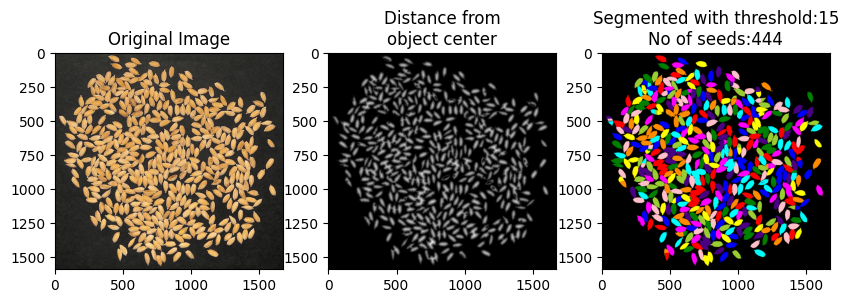

In [190]:
DISTANCE_THRESHOLD = 15

# 大津法にて背景分離を行います。
gray = rgb2gray(image)
threshold = threshold_otsu(gray)
binary = gray > threshold
# Distance transform to find markers for watershed
distance = ndi.distance_transform_edt(binary)
# Generate markers for the watershed
markers = label(distance > DISTANCE_THRESHOLD, connectivity=2)
# Apply watershed segmentation
lbl_image = watershed(-distance, markers, mask=binary)
# Convert label image to RGB image
segmented = label2rgb(lbl_image)

# Count Seeds
# 種子の数は　ユニークなラベル数値から背景（値が0）を１つ分引いたものに相当
seed_no = len(np.unique(lbl_image)) - 1

# Visualize the segmented regions
plt.figure(figsize=(10, 6))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(132)
plt.imshow(distance, cmap='gray')
plt.title('Distance from\nobject center')

plt.subplot(133)
plt.imshow(segmented, cmap='nipy_spectral')
plt.title('Segmented with threshold:'+ str(DISTANCE_THRESHOLD) + "\nNo of seeds:"+str(seed_no))
plt.show()

かなりの改善が見られました。DISTANCE_THRESHOLDの閾値を手動で変えてみることで、結果の変化が確認できます。
ただ、手動で値を変更し、最適な値を探索するのは大変です。0-30の間で検出可能な種子の数がどう変化するか自動探索してみましょう。


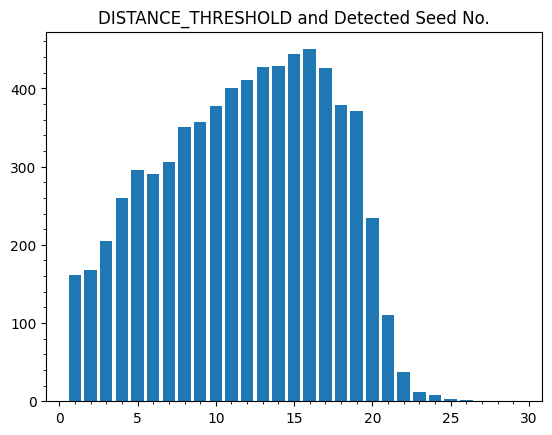

In [216]:
def get_seed_no_from_watershed(image, distance_threshold = 15):
    # 大津法にて背景分離を行います。
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    # Distance transform to find markers for watershed
    distance = ndi.distance_transform_edt(binary)
    # Generate markers for the watershed
    markers = label(distance > distance_threshold, connectivity=2)
    # Apply watershed segmentation
    lbl_image = watershed(-distance, markers, mask=binary)
    # Convert label image to RGB image
    segmented = label2rgb(lbl_image)
    seed_no = len(np.unique(lbl_image)) - 1
    return seed_no, lbl_image, segmented

result = []
for i in range(1,30):
    # 種子数のみ結果を集めます。画像は使いません
    seed_no, _, _ = get_seed_no_from_watershed(image, distance_threshold=i)
    result.append([i,seed_no])

result = np.array(result)

plt.title("DISTANCE_THRESHOLD and Detected Seed No.")
plt.bar(result[:,0],result[:,1])

# 補助メモリ線の表示
plt.minorticks_on()

値が14~16のときに最も多くの領域を検出できていそうです。

**ただし、この値は検出された領域の総数であって、真の種子数と同義ではないことに注意しましょう。**
得られた値は、過分割された種子も含まれますし、一方では、検出されなくなった種子も含まれません。

Text(0.5, 1.0, 'No of Seeds:429')

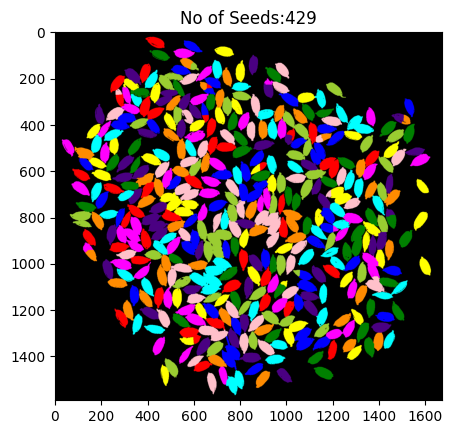

In [234]:
seed_no, lbl_image, segmented_image = get_seed_no_from_watershed(image, distance_threshold=14)
# Visualize the segmented regions
plt.figure(figsize=(5, 5))
plt.imshow(segmented_image, cmap='nipy_spectral')
plt.title("No of Seeds:"+str(seed_no))

この方法で単離された領域をもとに形状測定を行いましょう。

In [239]:
# 形状解析
# props = regionprops(lbl_image)
# 今回はみやすさのため、regionprops_tableを使います。

result_dict = regionprops_table(lbl_image, properties=["area","axis_major_length","axis_minor_length", "eccentricity","bbox","image"])
df = pd.DataFrame(result_dict)
df

area  axis_major_length  axis_minor_length  eccentricity  bbox-0  bbox-1  \
0    2646          85.254134          41.015213      0.876669      25     390   
1    2287          86.543921          34.237429      0.918420      40     556   
2    2628          81.148629          41.565586      0.858857      67     688   
3    2702          85.554114          40.703408      0.879574      75     511   
4    2458          85.043518          37.942916      0.894954      82     408   
..    ...                ...                ...           ...     ...     ...   
424  2949          87.171223          43.312656      0.867826    1447    1116   
425  2378          79.325459          38.784165      0.872326    1452     956   
426  2735          86.139815          40.850644      0.880397    1464     867   
427  4845          94.704422          71.343601      0.657644    1461     737   
428  2492          88.363601          36.581660      0.910281    1471     656   

     bbox-2  bbox-3                                              image  
0        75     473  [[False, False, False, False, False, False, Fa...  
1        92     636  [[False, False, False, True, True, False, Fals...  
2       111     773  [[False, False, False, False, False, False, Fa...  
3       117     603  [[False, False, False, False, False, False, Fa...  
4       129     496  [[False, False, False, False, False, False, Fa...  
..      ...     ...                                                ...  
424    1502    1201  [[False, False, False, False, False, False, Fa...  
425    1515    1024  [[False, False, False, False, False, False, Fa...  
426    1538     929  [[False, False, False, False, False, False, Fa...  
427    1569     816  [[False, False, False, False, False, False, Fa...  
428    1566     697  [[False, False, False, False, False, False, Tr...  

[429 rows x 9 columns]

<Axes: xlabel='Count', ylabel='axis_major_length'>

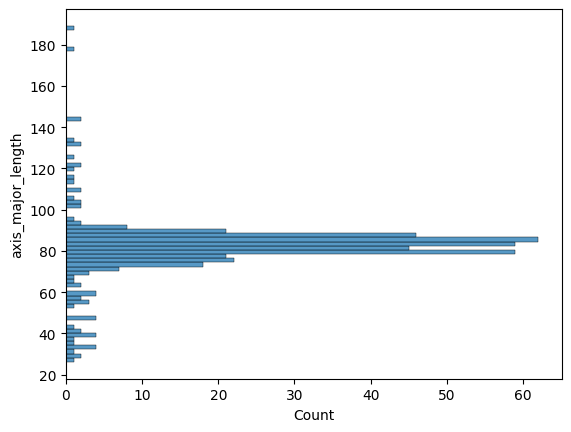

In [237]:
# 長軸長（px）の分布をみてみます。
sns.histplot(data=df, y="axis_major_length")
plt.show()

In [241]:
# Pandasデータフレームに含まれる検出ノイズを除去するために、四分位範囲（Interquartile Range, IQR）を使用してフィルタリングすることができます。

# IQRを計算する
Q1 = df['axis_major_length'].quantile(0.25)
Q3 = df['axis_major_length'].quantile(0.75)
IQR = Q3 - Q1

# 下限と上限を計算する
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 下限より小さい値または上限より大きい値を持つ行を削除する
filtered_df = df[(df['axis_major_length'] >= lower_bound) & (df['axis_major_length'] <= upper_bound)]

# フィルタリング後のデータを表示
filtered_df

area  axis_major_length  axis_minor_length  eccentricity  bbox-0  bbox-1  \
0    2646          85.254134          41.015213      0.876669      25     390   
1    2287          86.543921          34.237429      0.918420      40     556   
2    2628          81.148629          41.565586      0.858857      67     688   
3    2702          85.554114          40.703408      0.879574      75     511   
4    2458          85.043518          37.942916      0.894954      82     408   
..    ...                ...                ...           ...     ...     ...   
424  2949          87.171223          43.312656      0.867826    1447    1116   
425  2378          79.325459          38.784165      0.872326    1452     956   
426  2735          86.139815          40.850644      0.880397    1464     867   
427  4845          94.704422          71.343601      0.657644    1461     737   
428  2492          88.363601          36.581660      0.910281    1471     656   

     bbox-2  bbox-3                                              image  
0        75     473  [[False, False, False, False, False, False, Fa...  
1        92     636  [[False, False, False, True, True, False, Fals...  
2       111     773  [[False, False, False, False, False, False, Fa...  
3       117     603  [[False, False, False, False, False, False, Fa...  
4       129     496  [[False, False, False, False, False, False, Fa...  
..      ...     ...                                                ...  
424    1502    1201  [[False, False, False, False, False, False, Fa...  
425    1515    1024  [[False, False, False, False, False, False, Fa...  
426    1538     929  [[False, False, False, False, False, False, Fa...  
427    1569     816  [[False, False, False, False, False, False, Fa...  
428    1566     697  [[False, False, False, False, False, False, Tr...  

[375 rows x 9 columns]

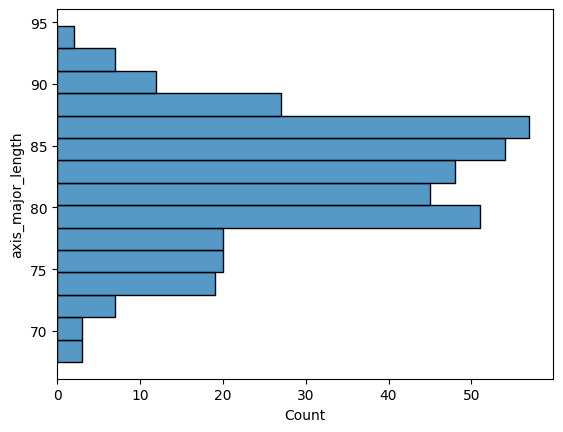

In [242]:
# 長軸長（px）の分布をみてみます。
sns.histplot(data=filtered_df, y="axis_major_length")
plt.show()
# だいぶすっきりしました。

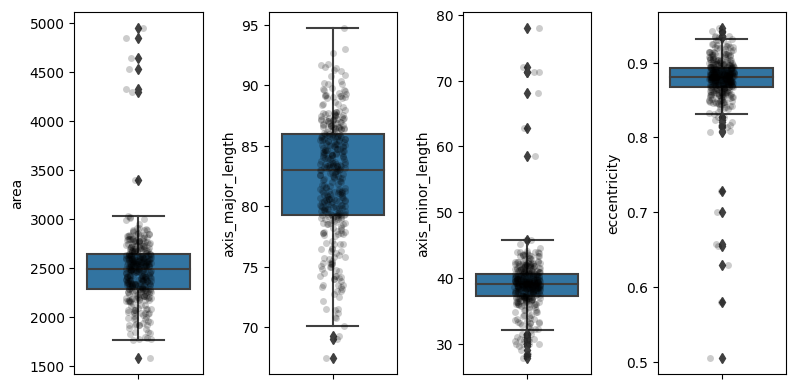

In [255]:
# area, axis_major_length, axis_minor_length, eccentricityの項目について描画します。
plt.figure(figsize=(10,4))
phenotype = ["area", "axis_major_length", "axis_minor_length", "eccentricity"]
for i, pheno in enumerate(phenotype):
    plt.subplot(1,len(phenotype)+1,i+1)
    sns.boxplot(filtered_df, y=pheno)
    sns.stripplot(filtered_df, y=pheno, c="black", alpha=0.2, jitter=True)
plt.tight_layout()


## Mask R-CNNを利用したイネ種子Instance Segmentation

### ONNX型式でのモデルの読み込み
実装はmatterportによるmaskrcnnのレポ。tensorflowやkerasのバージョン違い問題を回避するため、予め訓練済みモデルをonnxに変換してある。

In [60]:
import onnxruntime as ort

model_path = "/content/drive/MyDrive/phenotyping_temp_assets/rice_maskrcnn.onnx"
providers = ['CUDAExecutionProvider','CPUExecutionProvider']
ort_session = ort.InferenceSession(model_path, providers=providers)

# inputとoutputの名前を把握します。
input_names = [input.name for input in ort_session.get_inputs()]
output_names = [output.name for output in ort_session.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

# Colaboratoryでどのような実行プラバイダが利用できるか下のコマンドで表示します。優先度はリストの順番です。
# GPU利用を有効にしたcolaboratoryセッションでは['CUDAExecutionProvider', 'CPUExecutionProvider']のように表示されるはずです。
print(ort_session.get_providers())

Input names: ['input_image', 'input_image_meta', 'input_anchors']
Output names: ['mrcnn_detection', 'mrcnn_class', 'mrcnn_bbox', 'mrcnn_mask', 'ROI', 'rpn_class', 'rpn_bbox']
['CUDAExecutionProvider', 'CPUExecutionProvider']


### 推論

#### helper function
現在のColaboratory環境の都合上、matterport/maskrcnnから読み込めない機能は別途下のセルに書き出してあります。

In [134]:
import sys
sys.path.append("Mask_RCNN")

import mrcnn
from mrcnn.visualize import display_images
# from mrcnn.model import log
# import mrcnn.model as modellib
from mrcnn.config import Config
from mrcnn import utils, visualize

import numpy as np

#https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/model.py
def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta

def get_anchors(image_shape, config):
    """Returns anchor pyramid for the given image size."""
    backbone_shapes = compute_backbone_shapes(config, image_shape)
    # Cache anchors and reuse if image shape is the same
    _anchor_cache = {}
    a = utils.generate_pyramid_anchors(
        config.RPN_ANCHOR_SCALES,
        config.RPN_ANCHOR_RATIOS,
        backbone_shapes,
        config.BACKBONE_STRIDES,
        config.RPN_ANCHOR_STRIDE)
    # Keep a copy of the latest anchors in pixel coordinates because
    # it's used in inspect_model notebooks.
    # TODO: Remove this after the notebook are refactored to not use it
    anchors = a
    # Normalize coordinates
    _anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
    return _anchor_cache[tuple(image_shape)]

def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)

    # Currently supports ResNet only
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])

def unmold_detections(detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use in the rest of the
        application.

        detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
        mrcnn_mask: [N, height, width, num_classes]
        original_image_shape: [H, W, C] Original image shape before resizing
        image_shape: [H, W, C] Shape of the image after resizing and padding
        window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
                image is excluding the padding.

        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, num_instances] Instance masks
        """
        # How many detections do we have?
        # Detections array is padded with zeros. Find the first class_id == 0.
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]

        # Translate normalized coordinates in the resized image to pixel
        # coordinates in the original image before resizing
        window = utils.norm_boxes(window, image_shape[:2])
        wy1, wx1, wy2, wx2 = window
        shift = np.array([wy1, wx1, wy1, wx1])
        wh = wy2 - wy1  # window height
        ww = wx2 - wx1  # window width
        scale = np.array([wh, ww, wh, ww])
        # Convert boxes to normalized coordinates on the window
        boxes = np.divide(boxes - shift, scale)
        # Convert boxes to pixel coordinates on the original image
        boxes = utils.denorm_boxes(boxes, original_image_shape[:2])

        # Filter out detections with zero area. Happens in early training when
        # network weights are still random
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty(original_image_shape[:2] + (0,))

        return boxes, class_ids, scores, full_masks

def prepare_inputs(image, config):
    # based on detect class method of mrcnn
    # https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/model.py
    # cv2imread image data

    # mold imageの中身 リサイズとmean subtraction

    # molded_images, image_metas, windows = mrcnn.model.mold_inputs(images,config)

    # resizes an image keeping the aspect ratio unchanged.
    molded_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    molded_image = molded_image.astype(np.float32) - config.MEAN_PIXEL

    image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([config.NUM_CLASSES], dtype=np.int32))

    image_shape = molded_image.shape
    anchors = get_anchors(image_shape, config)
    anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)

    molded_images = np.expand_dims(molded_image,axis=0)
    molded_images = molded_images.astype(np.float32)
    image_metas = np.array([image_meta],dtype=np.float32)

    #windows is used for unmolding
    windows = np.array([window])





    # anchors = self.get_anchors(image_shape)
    # Duplicate across the batch dimension because Keras requires it
    # TODO: can this be optimized to avoid duplicating the anchors?
    # anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)
    return molded_images, image_metas, anchors, windows


#### 入力画像用意・推論・可視化

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

# モデル設定クラスmrcnnのConfigクラスを継承します
class InferenceConfig(Config):
    NAME = "seed"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + 1 seeds

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 8192
    IMAGE_RESIZE_MODE = "pad64"

    DETECTION_MAX_INSTANCES = 1000
    RPN_NMS_THRESHOLD = 0.4
    DETECTION_MIN_CONFIDENCE = 0

    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])


config = InferenceConfig()
# 画像を読み込み、configをもとにメタデータ、アンカー、ウィンドウなど推論に必要な情報を生成します。
image = cv2.imread("/content/drive/MyDrive/phenotyping_temp_assets/rice.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
molded_images, image_metas, anchors, windows = prepare_inputs(image, config)

In [143]:
print(molded_images.shape)
print(molded_images.dtype)
print(image_metas.shape)
print(image_metas.dtype)
print(anchors.shape)
print(anchors.dtype)

(1, 1600, 1728, 3)
float32
(1, 14)
float32
(1, 690525, 4)
float32


In [145]:
# 全部の出力を得る場合はNone、絞りたい場合は名前のリストを渡す。
# output = session.run(None, {input_name: input_data})
#　初回実行のみ時間がかかる
predictions = ort_session.run(
    ['mrcnn_detection', 'mrcnn_class', 'mrcnn_bbox', 'mrcnn_mask', 'ROI', 'rpn_class', 'rpn_bbox'],
    {"input_image": molded_images,
     "input_image_meta": image_metas,
     "input_anchors": anchors})

In [146]:
# 出力結果のうち、mrcnn_detectionとmrcnn_maskしか使わない。
detections = predictions[0]
mrcnn_mask = predictions[3]

results = []
final_rois, final_class_ids, final_scores, final_masks =\
    unmold_detections(detections[0], mrcnn_mask[0],
                            image.shape, molded_images[0].shape,
                            windows[0])
results.append({
    "rois": final_rois,
    "class_ids": final_class_ids,
    "scores": final_scores,
    "masks": final_masks,
})
r = results[0]

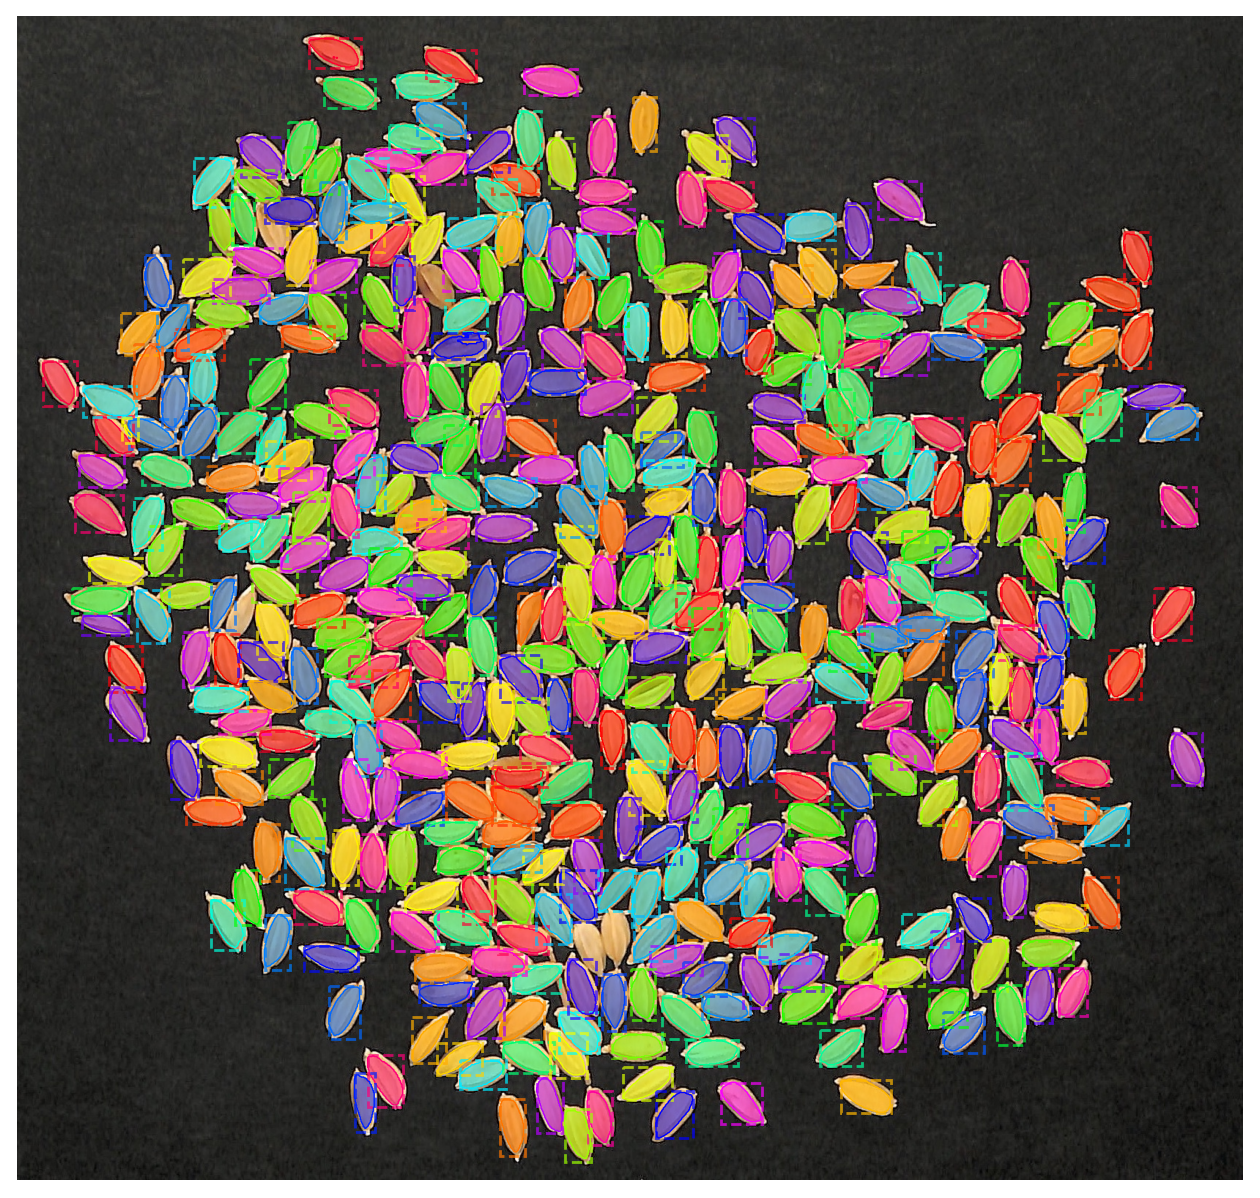

In [148]:
visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            ["",""], ["" for x in range(len(r['scores']))],　　　#ラベル["bg","seed"]と検出スコアは空白をいれて描画しなようにします
            show_bbox=True, show_mask=True,
            title="")

In [258]:
print(r["masks"].shape)
# 442粒分のマスク画像が格納されています

(1590, 1674, 442)


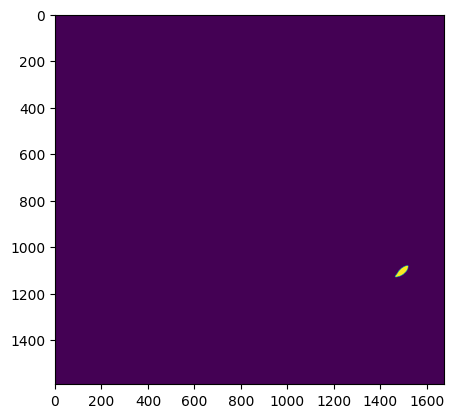

In [259]:
plt.imshow(r["masks"][...,0])

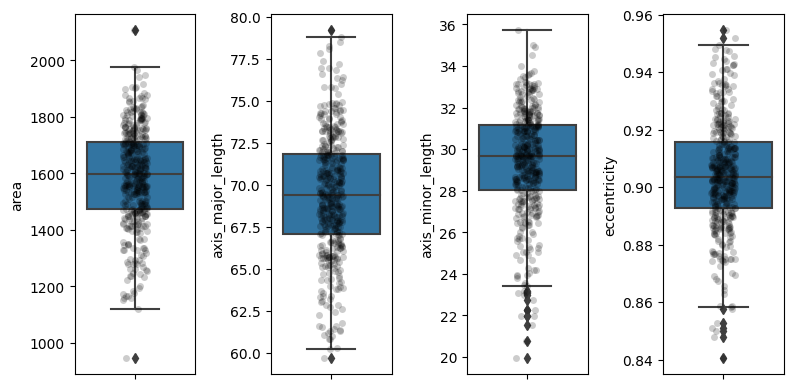

In [262]:
phenotype_list = []
for i in range(r["masks"].shape[-1]):
    mask = r["masks"][..., i]
    _lbl = label(mask)
    prop = regionprops(_lbl)[0]
    phenotype_list.append([prop.area, prop.axis_major_length, prop.axis_minor_length, prop.eccentricity])

df = pd.DataFrame(phenotype_list, columns=["area","axis_major_length","axis_minor_length","eccentricity"])

# IQRを計算する
Q1 = df['axis_major_length'].quantile(0.25)
Q3 = df['axis_major_length'].quantile(0.75)
IQR = Q3 - Q1
# 下限と上限を計算する
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# 下限より小さい値または上限より大きい値を持つ行を削除する
filtered_df = df[(df['axis_major_length'] >= lower_bound) & (df['axis_major_length'] <= upper_bound)]

# area, axis_major_length, axis_minor_length, eccentricityの項目について描画します。
plt.figure(figsize=(10,4))
phenotype = ["area", "axis_major_length", "axis_minor_length", "eccentricity"]
for i, pheno in enumerate(phenotype):
    plt.subplot(1,len(phenotype)+1,i+1)
    sns.boxplot(filtered_df, y=pheno)
    sns.stripplot(filtered_df, y=pheno, c="black", alpha=0.2, jitter=True)
plt.tight_layout()

なお、このモデルは種の領域を一回り小さく定義して取得するように訓練されているので、ノートブック前半のwatershed分割の結果よりも値が小さくなることに注意してください。